In [68]:
import lime
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lime import lime_image
from models.Bulbul import Bulbul
from Datasets.static_dataset import SpectralDataset
from skimage import r

In [52]:
explainer = lime_image.LimeImageExplainer()

In [202]:
df_test = pd.read_csv('storage/df_test_local.csv')
ds_test = SpectralDataset(df_test)
codes = pd.read_csv('storage/label_codes.csv').reset_index()
codes = codes.drop(columns=['index']).rename({'Unnamed: 0':'name'}, axis = 'columns')
codes

,name,code
0,emberiza_citrinella,0
1,turdus_philomelos,1
2,sylvia_atricapilla,2
3,loxia_curvirostra,3
4,fringilla_coelebs,4
5,parus_major,5
6,phylloscopus_trochilus,6
7,turdus_merula,7
8,phylloscopus_collybita,8
9,erithacus_rubecula,9


Test plotting:

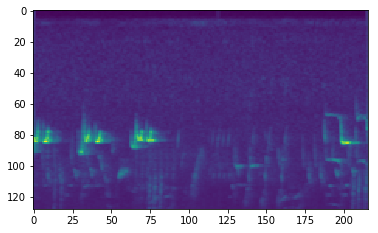

In [203]:
img = ds_test[34][0].squeeze()
img = img ** 0.17
#img = np.log(img + 1e-10)
plt.imshow(img)

In [69]:
Bulbul62 = 'checkpoint.86355c21-d360-4e03-8fbf-c1c37f7fd29f.tar' # Overfitted
model = Bulbul(128, 216, 10)
model.load_state_dict(torch.load(Bulbul62)['state_dict'])

In [298]:
transforms = []

In [299]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Algo options: 'quickshift', 'felzenszwalb', 'slic'

seg = SegmentationAlgorithm('felzenszwalb', 
                            kernel_size=4, 
                            max_dist=200, 
                            ratio=0.2, 
                            random_seed=1)

In [300]:
def transform_predict(array):    
    transformed = []
    for i in range(array.shape[0]):
        img = array[i].squeeze()
        transformed.append(rgb2gray(img))
    transformed = np.array(transformed)
    transforms.append(transformed)
    tensor = torch.Tensor(transformed).view(transformed.shape[0], 1, 128, 216)
    #print(tensor.max(), tensor.min())
    preds = model(tensor)
    return preds.detach().numpy()

def plot_explanations(explanation, true_label):
    fig = plt.figure(figsize=(20, 20))
    #fig.label(f'Lime Explanation. True Label = {true_label}')
    i = 1
    for label in explanation.top_labels:
        exp = explanation.get_image_and_mask(label)
        image, mask = rgb2gray(exp[0]), exp[1]
        ax = fig.add_subplot(len(explanation.top_labels), 1, i)
        ax.imshow(image)
        #plt.subplot(len(explanation.top_labels), 2, i+1)
        ax.imshow(np.ma.masked_where((mask == 1), mask), alpha = 0.7, cmap = 'Greys')
        ax.set_title(f'Name: {codes.name[label]}, Code: {label}')
        i+=1
    plt.tight_layout()
    plt.show()

def explain_spectrogram(dataset, idx, samples =1000):
    test_img = dataset[idx][0].squeeze() ** 0.17
    true_label = dataset[idx][1]
    explanation = explainer.explain_instance(test_img, transform_predict, top_labels=5, hide_color=0, num_samples=1000, segmentation_fn = seg)
    return explanation, true_label

0


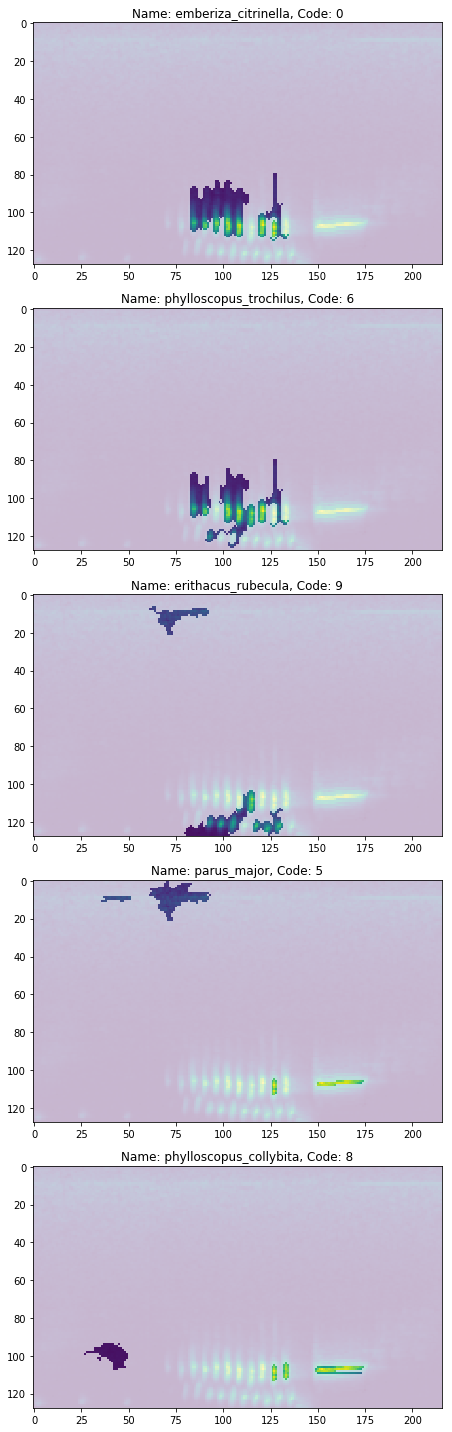

In [301]:
explanation, true_label = explain_spectrogram(ds_test, 1245)
print(true_label)
plot_explanations(explanation, true_label)

Having a look at the transforms generated:

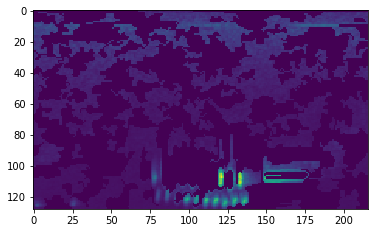

In [306]:
plt.imshow(transforms[4][7])

In [316]:
exp = explanation.get_image_and_mask(0)
image, mask = rgb2gray(exp[0]), exp[1]

In [317]:
from scipy.ndimage import gaussian_filter, convolve
smooth_mask = convolve(mask, np.ones((5,5)))

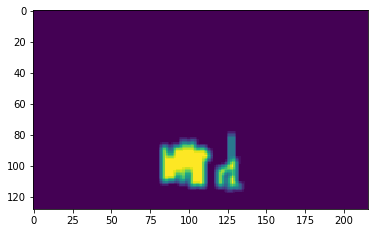

In [318]:
plt.imshow(smooth_mask)

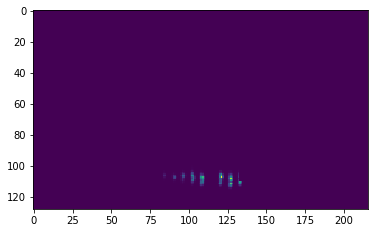

In [319]:
image_masked = np.where(smooth_mask > 0, image, 0)

plt.imshow(image_masked ** (1/0.17))